# Week 11 Section: Principal Components and Dimensionality Reduction
## Using PCA on the MNIST dataset
**Misha Gupta (11/22/24), Artur Rego-Costa (11/18/21), Danylo Lavrentovich (11/20/19), thanks to Dan Greenfield (11/10/19), Verena Volf, and James Xue**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from IPython.display import HTML, Image
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

np.random.seed(42) # set random seed

## Introduction
- Here we will use PCA on the [MNIST dataset of handwritten digits](https://en.wikipedia.org/wiki/MNIST_database), a common resource for testing data science tools!
- Working through this example should not only help you get more familiar with PCA, but also offer pointers and reference code for this week's PSet.
- While for the homework we would like you use singular value decomposition (SVD) to compute the principal components, in this notebook we will use canned functions from the `sklearn` PCA tool. You can take advantage of these functions yourself to compare outputs and troubleshoot your code!

The demonstration here is adapted from the Python Datascience handbook https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Some other good resources:
- Textbook on linear algebra: Introduction to Linear Algebra by Gilbert Strang
- Connections between PCA and SVD: https://intoli.com/blog/pca-and-svd/
- SVD: http://gregorygundersen.com/blog/2018/12/10/svd/

## Importing and visualizing the data

The MNIST dataset is included in `sklearn`.

In [2]:
# Import data
MNIST_DIGITS = load_digits()
X = MNIST_DIGITS.data
true_labels = MNIST_DIGITS.target
n, p = X.shape
print("(n, p): ", (n, p))

(n, p):  (1797, 64)


The data set we are analyzing contains a total of 1797 hand written digits, where each digit is comprised of 64 pixels. In this dataset, the $(i, j)$'th entry of `X` is the greyscale intensity of digit $i$ at pixel $j$.

We can visualize the whole dataset using a heatmap, for which I'll define a function that'll come in useful as we go through this example:

In [3]:
def plot_data_heatmap(X):
    '''
    Plot a heatmap of the data X.
    
    Input:
        X   Numpy array data matrix, where rows are observations, and columns are variables.
    '''
    max_intensity, min_intensity = np.max(X), np.min(X)

    plt.figure(figsize=(10,6))
    sns.heatmap(X, 
                cmap='Greys', vmin=min_intensity, vmax=max_intensity, 
                cbar_kws={'label': 'intensity', 'shrink': 0.75})
    plt.xlabel('pixel'); plt.ylabel('digit')
    plt.show()

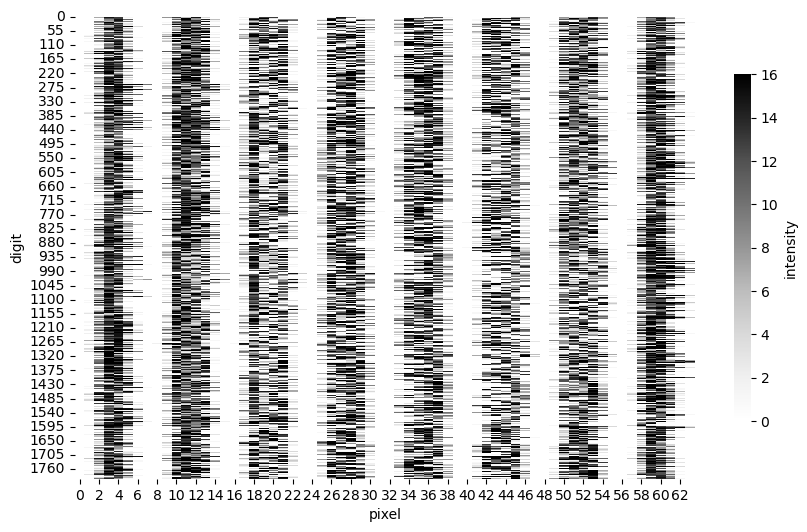

In [4]:
# plot data
plot_data_heatmap(X)

You can't really see the digits in this case, because we have flattened each 8x8 pixel image into a flat 64 pixel long row. Just to help you visualize what's going on, here is a function that takes the data and plots the individual digits wrapped in 8x8 pixel images:

In [5]:
def plot_digits(X, n_cols_fig = 10):
    '''
    Plot each digit in data X in its own 8x8 frame. Panels will be arranged in a grid 
    with n_cols_fig panels per row.
    
    Input:
        X            Numpy array data matrix, where rows are observations (digits), 
                     and columns are variables (pixels).
        n_cols_fig   Number of digits per row in final figure.
    '''
    n_digits, n_pixels = X.shape
    n_rows_fig = int(np.ceil(n_digits/n_cols_fig))
    
    fig, axes = plt.subplots(n_rows_fig, n_cols_fig, figsize=(n_cols_fig, n_rows_fig),
                                 subplot_kw={'xticks':[], 'yticks':[]},
                                 gridspec_kw=dict(hspace=0.1, wspace=0.1))

    for i, ax in enumerate(axes.flat[0:n_digits]):
        ax.imshow(X[i, :].reshape(8, 8), cmap='Greys', vmin = 0, vmax = 16)

And now we plot the first 35 digits in the data:

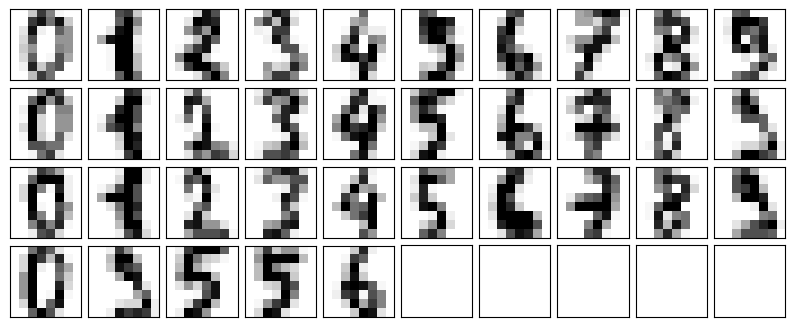

In [6]:
# plot each observation in itw own panel
plot_digits(X[0:35,])

In this week's PSet, Watson claims that each cell (observation), should cluster into one out of eight cell types (clusters) according to similarity in their RNAseq counts for each gene (variables). We will be using k-means and PCA to identify  to which clusters each observation belongs.

Now, in the current example, each hadnwritten digit (observation), maps back to a real digit (0, 1, 2, ..., 9; clusters), according to their 64 pixel values (variables). And so we'll also use PCA to help us in observing how do the handwritten digits cluster. The difference is simply that we already know the assignment of each observation (which digit the pixels represent) because this is a labelled dataset.  

So, let's first order the data according to which digit each observation belongs to, and examine the heatmap to see if our eyes can catch some patterns from the raw data (notice how I first use `np.argsort` to find the indices that would sort the array of labels, and then use it to sort the data!):

In [7]:
# find indices to reorder data according to digit assignment
ordering_indices = np.argsort(true_labels)

print("true_labels (cluster assignments): ", true_labels)
print("ordering_indices: ", ordering_indices)
print("ordered labels: ", true_labels[ordering_indices])

true_labels (cluster assignments):  [0 1 2 ... 8 9 8]
ordering_indices:  [   0  595  594 ...  535 1194 1572]
ordered labels:  [0 0 0 ... 9 9 9]


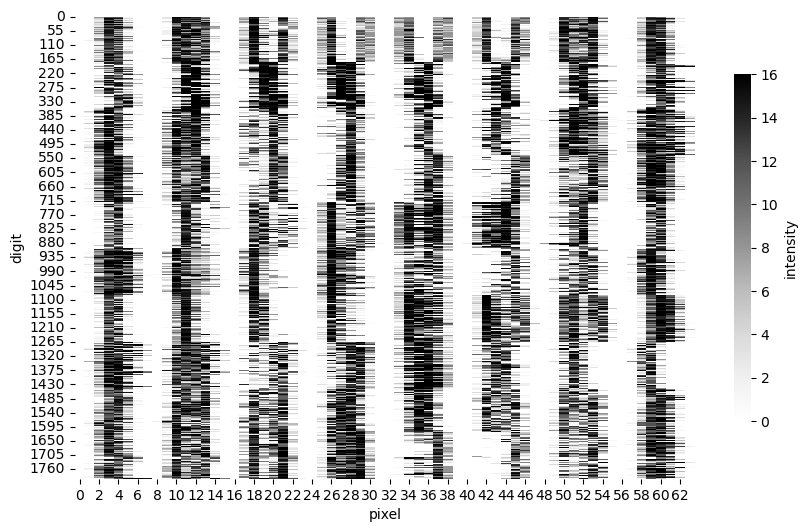

In [8]:
# plot reordered data
plot_data_heatmap(X[ordering_indices,])

From this we can already see some structure! We might even be able to recognize some of the digits if we stare for long enough.

But one thing that you should notice, is that the pixels (variables) do not all carry the same amount of information. For instance, these white columns in our heatmap represent pixels that never change in value across observations, and so they should not be useful in telling these digits apart. PCA is going to help us find the most informative pixels in our data.

Going one step further, we do not know how different pixels covary across observations, and how much information that carries. And that's what PCA is going to help us with! In other words, PCA is going to helps us find the linear combinations among pixels (variables) that lead to the largest spread in the data (observations), and that spread (we hope) will separate groups of observations into their respective digits. Let's see if that's really the case!

## Carrying out the PCA

Now we will do PCA on our `X` matrix using the canned `PCA` implementation from `scikit-learn`.

In [9]:
# carry out PCA
pca = PCA() # initialize empty PCA object
pca.fit(X) # carry out PCA on MNIST data

PCA()

The `pca` object now contains two objects of interest:
1. The principal component matrix $W$;
2. The vector of eigenvalues $\vec{\lambda}$ (ordered in descending order), which is the same as the diagonal of the $\Lambda$ matrix in the lecture notes. 

In [10]:
W = pca.components_.T # principal components; take note of the transpose!
lambdas = pca.explained_variance_ # 1D array of eigenvalues, ordered in descending order

To connect this back to the language we were using above to justify the use of PCA, each column of our matrix $W$ contains an eigenvector that encodes the orthogonal linear combination of variables (pixels) that are the most informative (spread the data the most) in descending order!

In your PSet, you will not be finding these objects by running a PCA tool like this one, and will instead need to compute them with SVD. Here's what you'll need to get started:

In [11]:
## TODO FOR YOU
# U_svd, S_svd, WT_svd = np.linalg.svd(?)

## Generating a negative control

In our homework we will have to decide how many of the principal components are actually informative to describe the structure of the data. For that, we will make use of eigenvalues values already given to us, which were comoputed on *negative control* data. While you will not need to generate this negative control yourself, it is useful to understand how something like this can be built, to help us understand what do we mean whenever we are deciding between *signal* and *noise* components. As there are many different ways one could think of making this call, our focus here will be on building intuition, rather than on being statistically rigorous in our language.

What we are often interested in doing whenever we use PCA is to find axes in the data space that capture more variance in the data than would be expected by simple noise from the data generating process. Of course, different data generating processes will have different noise patterns, and so that's why one needs to be careful on deciding what negative control do we even need for the task at hand. But one common approach (which, mind you, is not devoid of subtle assumptions), is to assume that if your data comes from pure noise, your variables would be all independent from each other. The result would be that your data would be spread out in data space in an uncorrelated fashion, meaning that it takes the shape of an ellipsoid that is only stretched and squished along the same coordinates as the data itself. A PCA run on that pure-noise data would pick PCs, but they should be picking only on the variances of independent variables in your data, and not on any covariance.

If this paragraph sounds confusing, it is because it is, so do not worry. Hopefully the construction of the negative control will be more intuitive.

A simple way to construct such a negative control for a given data `X`, is to do some sort of permutation or resampling of the data, each variable at a time (i.e. column-wise). Therefore breaking any structure in the data, but keeping the variance in each direction the same, as well as the total variance in the data. Here is a code that generates a null from the MNIST data by resampling (bootstrapping):

In [12]:
X_neg = np.zeros((n,p))
for j in range(p):
    X_neg[:,j] = np.random.choice(X[:,j], n, replace = True)

Which we can then plot:

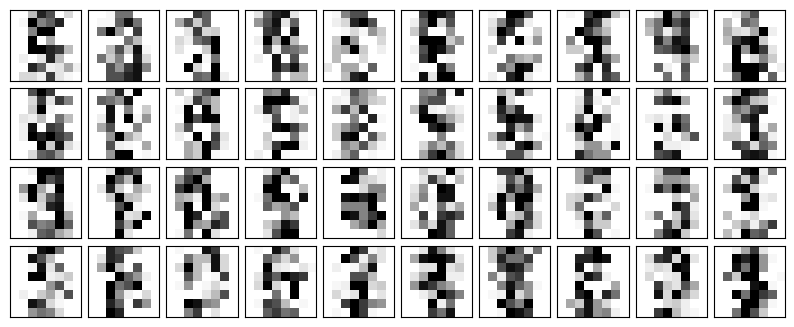

In [13]:
plot_digits(X_neg[0:40,],)

and run a PCA on just as we did for the real data:

In [14]:
pca_neg = PCA() # initialize empty PCA object
pca_neg.fit(X_neg) # carry out PCA on MNIST data
W_neg = pca_neg.components_.T # principal components; take note of the transpose!
lambdas_neg = pca_neg.explained_variance_ # 1D array of eigenvalues, ordered in descending order

## Finding signal components

As we have seen in class, the resulting eigenvalues from PCA will be equal to the amount of variance of the data explained by each of the principal components. In other words, each eigenvalue equals the variance in the projected values (scores) of the data onto the respective PC.

For starters, let's see how is it that the eigenvalues of the data compare to our negative control eigenvalues:

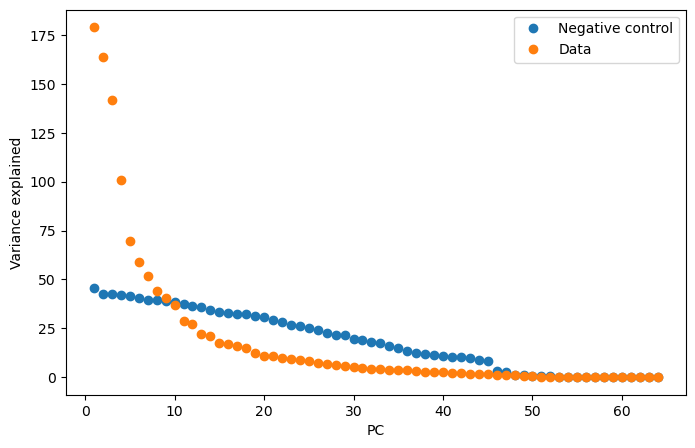

In [15]:
plt.figure(figsize=(8,5))
plt.plot(1+np.arange(p), lambdas_neg, 'o', label = "Negative control")
plt.plot(1+np.arange(p), lambdas, 'o', label = "Data")
plt.legend()
plt.xlabel('PC'); plt.ylabel('Variance explained')
plt.show()

We see that the first several eigenvalues of the data are higher than that of the negative control. Let's see how many, exactly.

In [16]:
for i in range(len(lambdas)):
    if lambdas[i] < lambdas_neg[i]:
        break
q = i # number of signal PCs
print("q: ", q)

q:  9


Therefore, we can be confident that the first 9 components of the PCA correspond to a spread in the data above what would be expected by noise. We should, nonetheless, be cautious with such statements, as what we get depends a lot in what negative control do we decide to do, which depends on your understanding of how the data is generated in the first place (a discussion we won't get into). Here, this works well, as our goal is much more that of data exploration, than of conducting well-principled hypothesis testing.

Finally, we will be interested not only in how much absolute variance each component explains, but also what proportion of the total variance does each component explain! For context, all the following ways of calculating the total variance in your data are equivalent:
1. $\textrm{trace}(\Sigma)$; the sum of the diagonal of the covariance matrix;
2. $\textrm{trace}(\Lambda)$; the sum of the eigenvalues you would get from eigendecomposing your data matrix X;
3. $\textrm{trace}(S^2/(n-1))$; the sum of the adjusted singular values you would get from SVD.

Fortunately for us, the PCA tool already outputs the fraction of the total variance explained by each principal component:

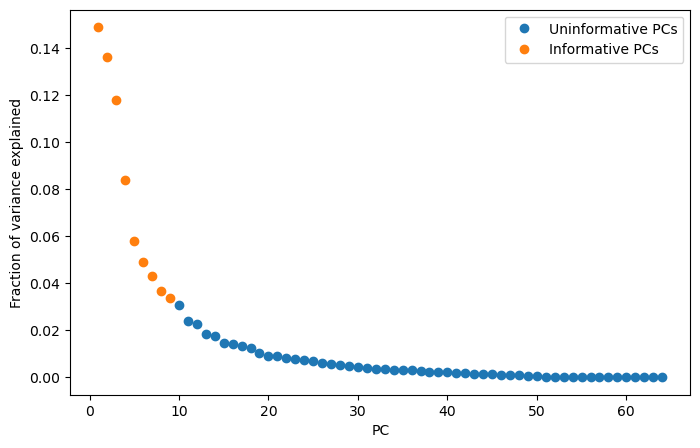

In [17]:
var_explained = pca.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(1+np.arange(p)[q:], var_explained[q:], 'o', label = "Uninformative PCs")
plt.plot(1+np.arange(p)[:q], var_explained[:q], 'o', label = "Informative PCs")
plt.legend()
plt.xlabel('PC'); plt.ylabel('Fraction of variance explained')
plt.show()

You, on the other hand, will have to calculate it yourself from your SVD output:

In [18]:
## TODO FOR YOU
## get the fraction of variance captured by each PC starting with the S array.
## it should equal pca.explained_variance_ratio!!

explained_variances_from_svd = 'insert code here'

Another useful way of looking at variance explained, since we will always keep the first $q$ PCs, is to examine how much of the total variance is explained as we keep more and more PCs:

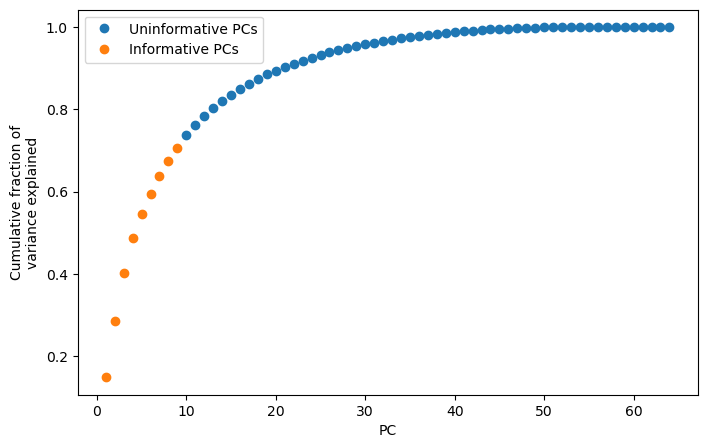

In [19]:
cumulative_var_explained = np.cumsum(var_explained)

plt.figure(figsize=(8,5))
plt.plot(1+np.arange(p)[q:], cumulative_var_explained[q:], 'o', label = "Uninformative PCs")
plt.plot(1+np.arange(p)[:q], cumulative_var_explained[:q], 'o', label = "Informative PCs")
plt.legend()
plt.xlabel('PC'); plt.ylabel('Cumulative fraction of\nvariance explained')
plt.show()

from which we see that what we called as informative PCs jointly explain about 70% of the total variance in the data.

## Scores: visualizing the data in lower-dimensional PC space

Our original data is 64-dimensional, but we have only kept a small number $q$ of informative PCs, which should make it easier to visualize how our data is spread in data space.

Luckily for us, `sci-kit`'s PCA analysis has a convenient function to help us project our data onto PC space:

In [20]:
Y = pca.fit_transform(X) # Data projected onto PC space

Just as the data matrix $X$ itself, rows of $Y$ correspond to observations, but columns are now projections of the data onto PC space. In your PSet, you will have to calculate these projections for yourself from the SVD outputs:

In [21]:
## TODO FOR YOU
## get the projections of the data onto PC space using the appropriate information from U, S, W^T.

Y_from_svd = 'insert code here'

# check that they're similar
#plt.figure()
#plt.scatter(Y_from_svd[:,0], Y[:,0])
#plt.show()

Now let's try and visualize the data!

First, let's write a function to plot our data and add digit labels:

In [22]:
def plot_labelled_scatter(X, labels, xlabel = "x1", ylabel = "x2"):
    '''
    Plot either the original data or the projected data, labelled into groups according to labels.
    
    Input:
        X               Numpy matrix of two columns, where observations are rows, 
                        and columns are variables.
        labels          Array of labels of each observation.
        xlabel, ylabel  Figure axes labels
    '''
    cmap = plt.cm.get_cmap('jet', 10)

    plt.figure(figsize=(7,7))
    
    # scatter plot as before, but colored by true label
    plt.scatter(X[:,0], X[:,1],
                c=labels, edgecolor='none', alpha=0.7,
                cmap=cmap)

    # add text label 0-9 to the centroid of each digit cluster
    for digit in np.arange(10):
        where_digit = np.where(labels == digit)
        projections_subset = X[where_digit]
        centroid = np.mean(projections_subset, 0)
        # add white stroke to text, thanks to:
        # https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
        txt = plt.text(*centroid, digit, c='k', size=12)
        txt.set_path_effects([PathEffects.withStroke(linewidth=6, foreground='w')])

    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.colorbar(shrink=0.75, label='true digit')
    plt.axis('square')
    plt.show()

Now, before we visualize the projected data, let's find out how the digits cluster in relation to any two (supposedly) randomly picked pixels from the dataset.

/var/folders/fg/0rqq1vx12tx_3cp5p06n00640000gn/T/ipykernel_22564/2037821020.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 10)


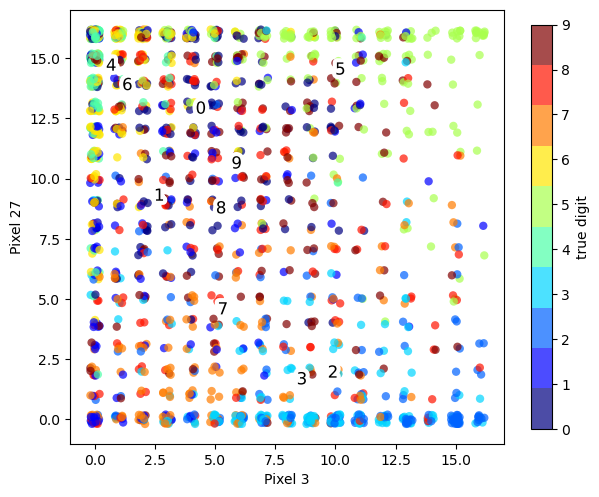

In [23]:
plot_labelled_scatter(X[:,[2,26]] + 0.2*(np.random.random((n,2))*2 - 1), # add jitter to data
                      true_labels, xlabel = "Pixel 3", ylabel = "Pixel 27")

We can seem some structure! But there is still a significant amount of overlap that makes digits virtually indistinguishable from each other.

Now let's examine the first two principal components, which are the two orthogonal linear combinations of pixel values that explain the most variance in the data.

/var/folders/fg/0rqq1vx12tx_3cp5p06n00640000gn/T/ipykernel_22564/2037821020.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 10)


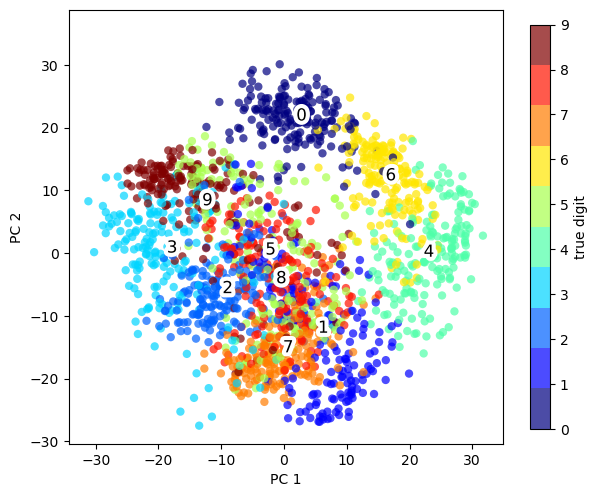

In [24]:
plot_labelled_scatter(Y[:,[0,1]], true_labels, xlabel = "PC 1", ylabel = "PC 2")

We see a lot more structure here! 

For instance, all of the digits that are truly 0 seem to cluster together in this PC space. The next nearest cluster of points appears to be the 6's -- not surprising, those are curvy too. 

Now, let's look at a few other pairs of PCs to see how much more informative are they.

/var/folders/fg/0rqq1vx12tx_3cp5p06n00640000gn/T/ipykernel_22564/2037821020.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 10)


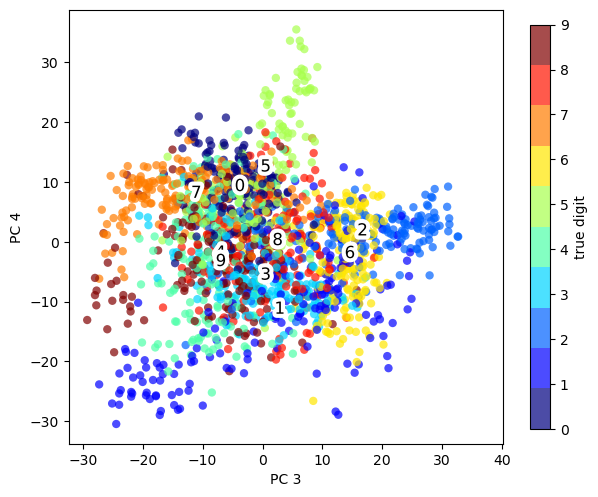

In [25]:
plot_labelled_scatter(Y[:,[2,3]], true_labels, xlabel = "PC 3", ylabel = "PC 4")

/var/folders/fg/0rqq1vx12tx_3cp5p06n00640000gn/T/ipykernel_22564/2037821020.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 10)


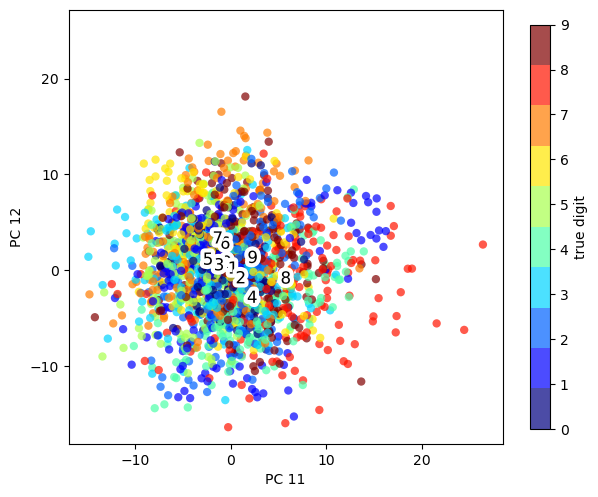

In [26]:
plot_labelled_scatter(Y[:,[10,11]], true_labels, xlabel = "PC 11", ylabel = "PC 12")

I hope it is very clear from these examples how the first few PCs hold most, if not all of the structure in the data.

## Loadings: which variables are most important

Now let's take the first principal component and plot the entries of it. This gives a look into the contribution of each dimension into the direction that we know explains the most variation among the hand-drawn digit datapoints.

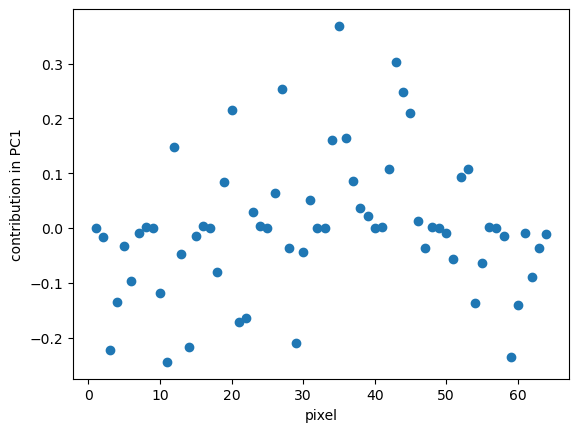

In [27]:
PC1 = W[:,0]

plt.figure()
plt.plot(1+ np.arange(p), PC1, 'o')
plt.xlabel('pixel'); plt.ylabel('contribution in PC1')
plt.show()

A lot of pixels have a contribution of around 0 in this PC, so they're not contributing much in this "direction" that we know explains a sizable fraction of the variance in the data.

I will arrange the first PC into an 8x8 grid and then color each entry just to make it easier to look at/think about in context of the 8x8 images, but remember that this whole time, the dimensionality of the data is 64 pixels.

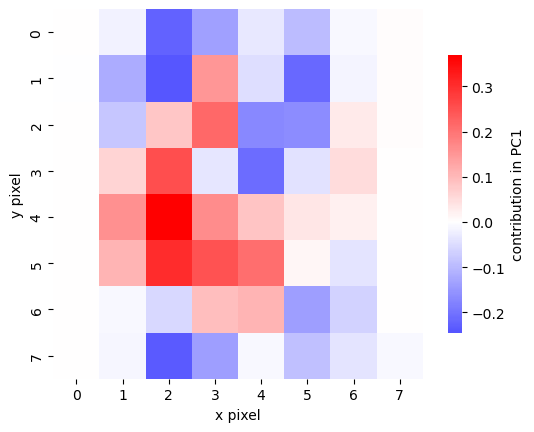

In [28]:
plt.figure()
plt.axis('square')
sns.heatmap(PC1.reshape((8, 8)), 
            cmap='bwr', center=0,
            cbar_kws={'label': 'contribution in PC1', 'shrink': 0.75})
plt.xlabel('x pixel'); plt.ylabel('y pixel')
plt.show()

Let's take such a look at the first 10 eigenvectors, where red indicates a positive contribution in the PC, and blue, a negative contribution:

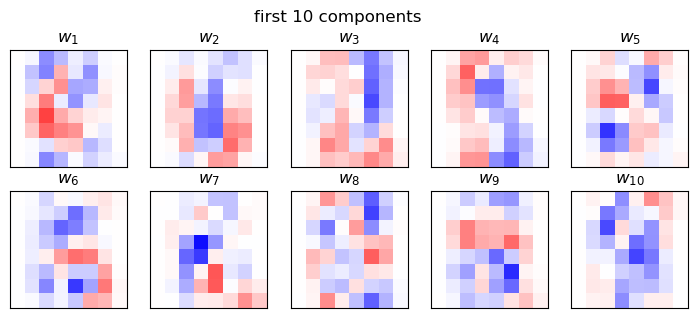

In [29]:
n_rows = 2
n_cols = 5

n_to_show = n_rows * n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(1.75*n_cols, 1.75*n_rows),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.2))

plt.suptitle(f'first {n_to_show} components')
for i in range(n_to_show):
    subplot_row = i // n_cols
    subplot_col = i % n_cols
    cur_ax = axes[subplot_row, subplot_col]
    cur_ax.set_title('$w_{'+f'{i+1}'+'}$')
    cur_ax.imshow(pca.components_[i, :].reshape((8,8)), cmap='bwr', vmin=-0.5, vmax=0.5)

- The first component seems to have large positive weights on pixels in the middle-left ish part of the grid. If we look at the projections of the digits onto the first PC (the value along the x axis in the plot we made earlier), digits with a large projection onto PC1 should have a lot of intensity in those red pixels in the left of the grid. Does it make sense that 4s have a large projection onto this PC, while 3s do not? It can help to think of "projection onto" as "overlap with"
- The second component seems to represent something like curviness along the bottom right and middle left. Does it make sense that 0s would score highly on this PC, but that 7s score very lowly?

## Optional, for the curious: Reconstruction and denoising data

All that we have done with PCA so far is project the data in a different coordinate system that makes its structure clearer. But that comes with a tradeoff, because now each coordinate (principal component) is harder to interpret: it is a linear combination of many variables. And so, at times, we will be interested in using PCA to find the principal components of our data that capture most of the variance, and then reproject only those components back into the original coordinate system, which might have coordinates that are more readily interpretable.

Let's take the case of the PCA of the MNIST digits. The matrix $Y$ of our data projected onto the principal components has the same dimensions as that of the original dataset (only because $p \gt n$; in the pset, Y will be an $n\times n$ matrix because $p \lt n$), and so we can try and visualize it with the same tools we were using to visualize the digits:

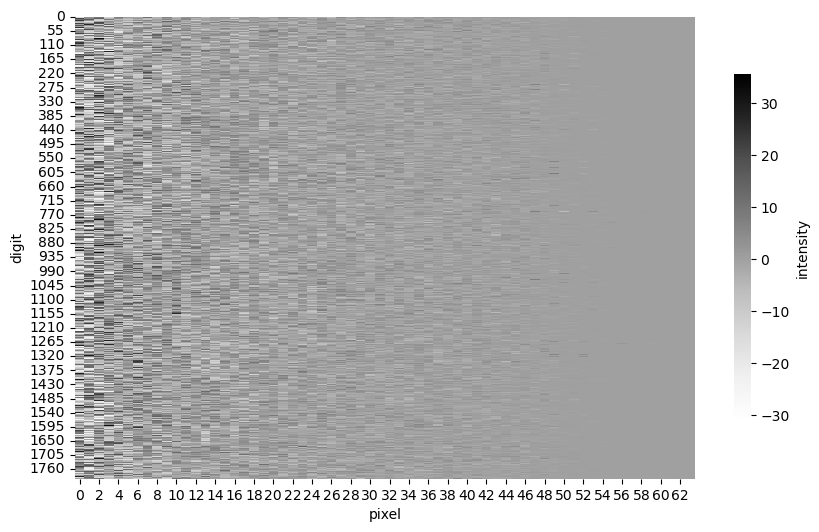

In [30]:
# plot heatmap of PCA scores for all observations
plot_data_heatmap(Y)

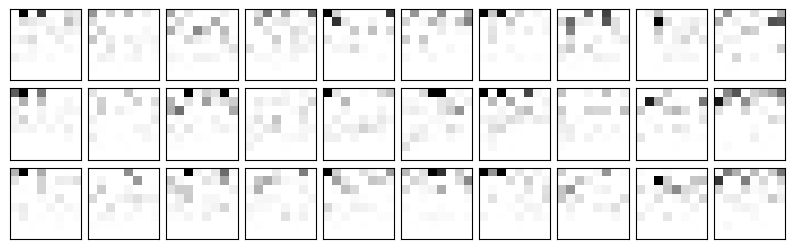

In [31]:
# Try and wrap PCA scores into 8x8 frames...
plot_digits(Y[:30,:])

The structure of the data might be clearer (hence the scatterplots in the previous section), but that doesn't help us read back the digits (as seen above). We (I, at least) only know how to identify digits in the original coordinate system (where each dimension is a pixel). But I'm still interested in getting rid of some of the noise present in the original data.

For projecting data from PCA into coordinate system, `sci-kit` has a nicely implemented method, although in order to use it to denoise the data, I had to take the first $q$ columns of $Y$ and pad the rest with 0's, which is equivalent to ignoring PC's $q + 1$ through $n$:

In [32]:
Xq = pca.inverse_transform(np.concatenate((Y[:,np.arange(q)], np.zeros((n,p - q))), axis = 1))

For your homework, you will have to do the same thing using the objects you get from SVD.

In [33]:
## TODO FOR YOU
## get the first q scores of each observation projected back into the original
## coordinate system using Y (from above), U, S, and W^T.

Xq_from_svd = 'insert code here'

# check that they're similar
#plt.figure()
#plt.scatter(Xq_from_svd[:,0], Xq[:,0])
#plt.show()

Now let's compare the reconstructed and the original digits:

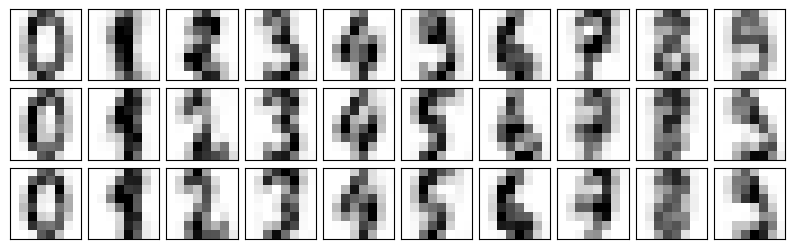

In [34]:
# Plot reconstructed digits
plot_digits(Xq[:30,:])

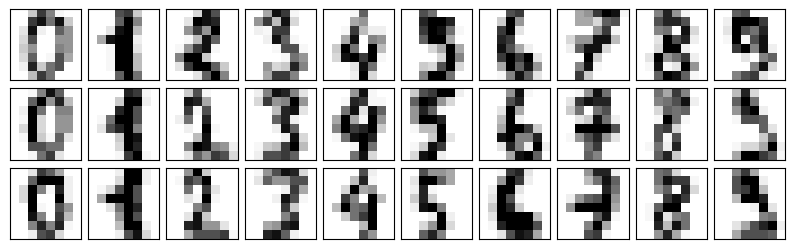

In [35]:
# Plot original digits
plot_digits(X[:30,:])

At first look, it might seem not very satisfying. Denoising didn't really make the digits easier for us to read. But that's not the way to understand what PCA has done. Denoising has removed a lot of the variation present in the original data, making the reconstructed data more homogeneous! For instance, compare the 0's between the original and reconstructed digits. Which of those have less variation among observations? What about the 7's?

### Reconstruct raw or zero-centered data?
It is common practice to zero-center the data prior to carrying out PCA. This is no way a requirement of PCA (although it is a requirement for using SVD for inferring the PCA eigenvectors and eigenvalues! And so do it for the PSet!), but it is often useful for the specific situation of projecting PC scores back to the original coordinate system. So here's a little demonstration.

Below, I am taking the first $q$ PC scores calculated from uncentered data, projecting them back using the eigenvectors $W$ into the original coordinate system, and then visualizing the digits as done above:

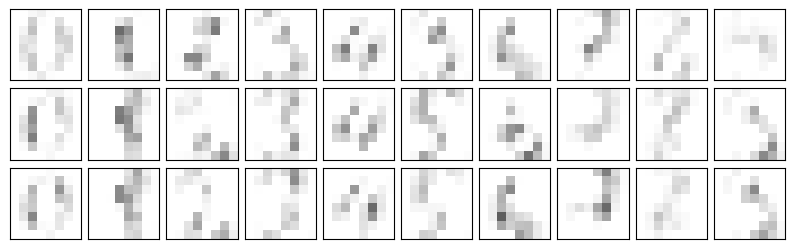

In [36]:
Xq_test = (Y[:,:q])@(W[:,:q].T)
plot_digits(Xq_test[:30,])

What you can see, is that the digits are much less pronounced than in the reconstruction we did at first. That's because this process of reconstruction from a subset of all PC's does not preserve the mean of the original data! In fact, any variable (pixel) that is not very informative, i.e. has a small loading in the first $q$ PCs, will end up with small values close to 0 when reconstructed back in the original coordinate system. Therefore, all these darker pixels that, despite not being informative for the sake of data structure, would make the digit traces more vivid to our eyes, get turned into very small values (white, in this case) upon reconstruction.

It is for this reason that it is common practice for PCA to be carried out on zero-centered data, and for the mean of the original data to be added to the denoised data upon reconstruction. Apparently, that is what the `sci-kit`'s `inverse_transform()` method does in the background, and that's why we didn't see this issue when we used it to reconstruct the data.

For each digit, we will take its projection onto each of the principal components, then we will re-express the original digit in the basis of the principal components. In other words, we'll express a digit like 

```
reconstructed data = 
    (pixel-wise mean) 
    + (centered data's projection onto PC1) * PC1 
    + (centered data's projection onto PC2) * PC2 
    + ... 
    + (centered data's projection onto PC8) * PC8
```

/var/folders/fg/0rqq1vx12tx_3cp5p06n00640000gn/T/ipykernel_22564/555476708.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  r"${}{:.2f} \cdot w_{}$".format('+'*(coefficients[i]>0), coefficients[i], i + 1))


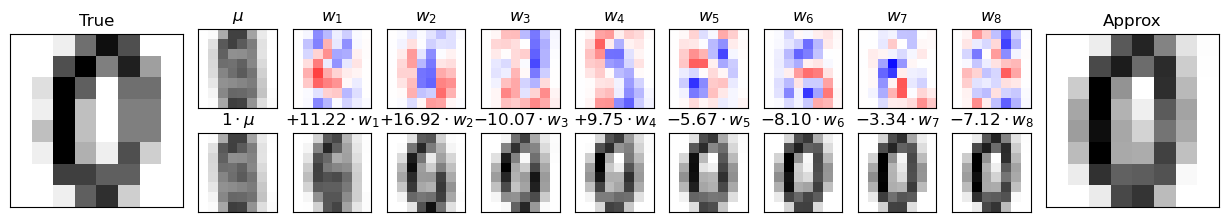

In [37]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    '''
    a purposefully obtuse function
    '''
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None, cmap='binary', vmin=0, vmax=16):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest', 
                  cmap=cmap, vmin=vmin, vmax=vmax)
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], 
             r'$w_{0}$'.format(i + 1), cmap='bwr', vmin=-0.5, vmax=0.5)
        show(1, i + counter, approx,
             r"${}{:.2f} \cdot w_{}$".format('+'*(coefficients[i]>0), coefficients[i], i + 1))

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

Xproj = pca.fit_transform(X)[:, :8]
fig = plot_pca_components(X[10], Xproj[10],
                          pca.mean_, pca.components_)

The panel on the left is the true image. The panel on the right is the image upon reconstruction using the first eight principal components. Notice that the mean, $\mu$, is added first since in the original data matrix, we subtracted the column means from the data, we need to add it back to reconstruct the data. The first row represents the eigenvectors.  $w_i$ represents the $i$th column of the eigenvector matrix $W$. The row in the middle shows the incremental sum of including each eigenvector multiplied by the projection of the digit onto that eigenvector. 

We can kind of tell it's a 0 already by adding in the second component, which adds curviness on the bottom right and middle left.

Another way that PCA can be used is to remove noise from lower dimensions. Let's add random noise to the handwritten digits data, keep the top 8 principal components, then reconstruct the data.

/var/folders/fg/0rqq1vx12tx_3cp5p06n00640000gn/T/ipykernel_22564/555476708.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  r"${}{:.2f} \cdot w_{}$".format('+'*(coefficients[i]>0), coefficients[i], i + 1))


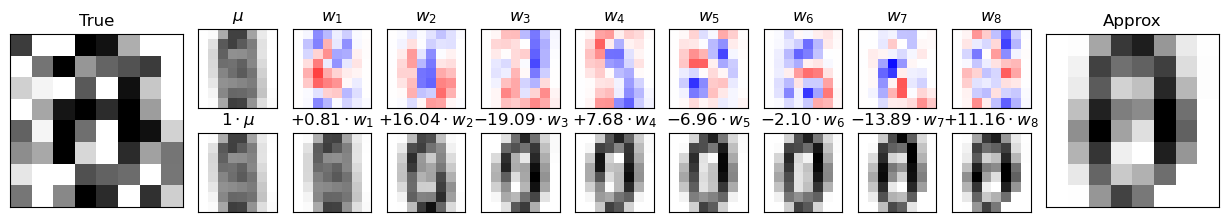

In [38]:
np.random.seed(123)
X_noisy = np.random.normal(X, scale=8)

Xproj_noisy = pca.transform(X_noisy)[:, :8]
fig = plot_pca_components(X_noisy[10], Xproj_noisy[10],
                          pca.mean_, pca.components_)

Wow, when we take a super noise-corrupted digit, and we subtract out the pixel means (computed from the original set of digits), then project the (centered) noisy digit onto the space spanned by the eight PCs trained on our original set, and reconstruct the digit, we can remove a lot of the noise and squint at it to say it's a 0 (well, maybe an 8).

In [39]:
## TODO FOR YOU
## use the information in U, S, W to project the following mystery digit to the first 8 PCs of the original data, X

noisy_mystery_digit = np.array([-2.85, -4.32,  5.46, 15.34, 15.38, -2.84,  2.08, -1.01,  2.  ,
        0.38, 20.61, 16.65, 13.62, 14.5 ,  3.3 , -6.98, -0.  ,  1.93,
       12.97,  0.19, 11.02, 17.6 , -1.49,  5.81, -0.23,  7.59, 12.79,
       15.48, 15.34, 19.05, -3.87, -4.03, -4.9 , -2.48, -1.91,  7.96,
       12.04, 15.41,  1.57,  8.29,  5.62, -2.06, -6.38,  3.3 ,  2.42,
       14.37,  0.83,  1.49, -4.83,  1.5 , -0.54,  8.96,  1.41, 17.34,
        3.8 , -4.1 ,  1.34, -5.24, 15.96, 13.23, 15.48,  6.64, -0.93,
       -0.38])

## code scaffold supplied here
noisy_digit_centered = ''
q = 8
Wq = ''
projection_onto_Wq = ''
reconstructed_noisy_digit = ''